# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 175 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=4a932d6e6ed4d8894badc68d0c5e17ff1f142e130431af179390e42367016fb1
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


## Set Up paths

In [2]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path
folder_path = 'team project/codes/models/cyberbullying/'

#Specific paths
path_train = parent_path+"team project/data set/dataset search/Cyberbullying Data/cyberbullying_tweets.csv" 
path_proprocessed = parent_path+"team project/data set/dataset search/Cyberbullying Data/text_without_sw.csv" 

path_hyperparameters_sgd = parent_path+ folder_path + "best_parameters/sgd.csv"
path_hyperparameters_svm = parent_path+folder_path +"best_parameters/svm.csv"
path_hyperparameters_et = parent_path+folder_path +"best_parameters/et.csv"
path_hyperparameters_rf = parent_path+folder_path +"best_parameters/rf.csv"
path_hyperparameters_nb = parent_path+folder_path +"best_parameters/nb.csv"
path_hyperparameters_knn = parent_path+folder_path +"best_parameters/knn.csv"
path_hyperparameters_lr = parent_path+folder_path +"best_parameters/lr.csv"
path_hyperparameters_dt = parent_path+folder_path +"best_parameters/dt.csv"

path_best_parameters_sgd = parent_path+folder_path +"/sgd.pkl"
path_best_parameters_svm = parent_path+folder_path +"/svm.pkl"
path_best_parameters_et = parent_path+folder_path +"/et.pkl"
path_best_parameters_rf = parent_path+folder_path +"/rf.pkl"
path_best_parameters_nb = parent_path+folder_path +"/nb.pkl"
path_best_parameters_knn = parent_path+folder_path +"/knn.pkl"
path_best_parameters_lr = parent_path+folder_path +"/lr.pkl"
path_best_parameters_dt = parent_path+folder_path +"/dt.pkl"

## Set Up Functions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Data Exploration

In [4]:
train = pd.read_csv(path_train)

In [5]:
print(train.shape)
print(train.head())
print(train.cyberbullying_type.unique())
print(train.isnull().any())
train.rename(columns = {'tweet_text':'text', 'cyberbullying_type':'label'}, inplace = True)
print(train.columns)

(47692, 2)
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']
tweet_text            False
cyberbullying_type    False
dtype: bool
Index(['text', 'label'], dtype='object')


# Data Preprocessing

# Emoji Detection

In [6]:
print('Supported languages: {}'.format(list(emoji.UNICODE_EMOJI.keys())))
print('First five emoticons in English: {}'.format(list(emoji.UNICODE_EMOJI['en'].items())[0:5]))

Supported languages: ['en', 'es', 'pt', 'it', 'fr', 'de']
First five emoticons in English: [('🥇', ':1st_place_medal:'), ('🥈', ':2nd_place_medal:'), ('🥉', ':3rd_place_medal:'), ('🆎', ':AB_button_(blood_type):'), ('🏧', ':ATM_sign:')]


In [7]:
content = train['text']
label = train['label']
list_texts = list(content)

list_only_texts = []
for text in list_texts:
  pure_text = emoji.demojize(text, language='en')
  list_only_texts.append(pure_text)

## Data Cleansing

In [8]:
def dataCleansing(data):

    # Convert text to lowercase
    data = data.lower()
    
    #Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    #Remove non-english words
    data =  re.sub("[^a-z]+", " ",data)
        
    return data

preprocessed_text = []
for i in range(len(list_only_texts)):
    preprocessed_text.append(dataCleansing(list_only_texts[i]))
preprocessed_text[:5]

['in other words katandandre your food was crapilicious mkr',
 'why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc',
 ' xochitlsuckkks a classy whore or more red velvet cupcakes ',
 ' jason gio meh p thanks for the heads up but not too concerned about another angry dude on twitter ',
 ' rudhoeenglish this is an isis account pretending to be a kurdish account like islam it is all lies ']

## Tokenization 

In [9]:
stop_words = set(stopwords.words('english')) 

list_tokens = []
# for every tweet tokenize
for text in preprocessed_text:
  word_tokens = word_tokenize(text) 
  list_tokens.append(word_tokens)

list_all_filtered = []
for tokens in list_tokens: 
  list_filtered = [] 
  for word in tokens: 
      if word not in stop_words: 
          list_filtered.append(word) 
  list_all_filtered.append(list_filtered)


In [10]:
# preprocessed text without stopwords saved in csv
list_text_without_sw = []
for tokens in list_all_filtered:
  sentence = ' '.join(tokens)
  list_text_without_sw.append(sentence)
print(list_text_without_sw[1])


text_without_sw = pd.DataFrame(list_text_without_sw,columns=['text'])
text_without_sw = pd.concat([label,text_without_sw], axis=1)
text_without_sw.to_csv(path_proprocessed,index=False)
text_without_sw.head()

aussietv white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc


,label,text
0,not_cyberbullying,words katandandre food crapilicious mkr
1,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,not_cyberbullying,xochitlsuckkks classy whore red velvet cupcakes
3,not_cyberbullying,jason gio meh p thanks heads concerned another...
4,not_cyberbullying,rudhoeenglish isis account pretending kurdish ...


# Balance Dataset

In [11]:
# loading preprocessd data
df = pd.read_csv(path_proprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

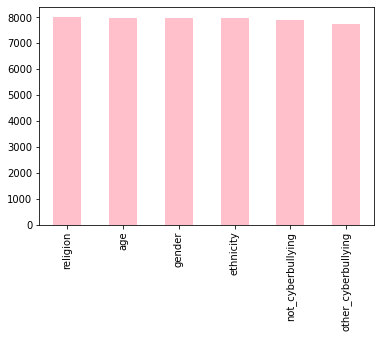

In [12]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [13]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(38047,)
(4756,)
(4756,)


38621    girl mankhurd region mumbai bullied muslim res...
43698    done girl naive dumb fuck white people think t...
38061    chapter far trump dad vile step anyone anythin...
3373                                           wtf mkr mkr
8972                               feministlah tag founder
                               ...                        
4014     kat andre reaction annie lloyd disgusting dese...
47416      tosh fuck u nigger asshole fat ass dumb shit ok
10173    reminder gay jokes prison rape jokes never fun...
23192    islam respect religions verse quran show juziy...
38941                           jimmy wilkins school bully
Name: text, Length: 38047, dtype: object

# Training Models in a Pipeline

## Pipeline Set Up

In [17]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score, average='weighted')

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [18]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 861.3408532142639 seconds ---
Multinomial NBClassifier: 76.77974655173023% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': True}


['/content/drive/My Drive/team project/codes/models/cyberbullying//nb.pkl']

                     precision    recall  f1-score   support

                age       0.75      0.99      0.85       799
          ethnicity       0.88      0.95      0.92       796
             gender       0.84      0.88      0.86       797
  not_cyberbullying       0.69      0.38      0.49       792
other_cyberbullying       0.63      0.53      0.57       772
           religion       0.83      0.97      0.90       800

           accuracy                           0.78      4756
          macro avg       0.77      0.78      0.76      4756
       weighted avg       0.77      0.78      0.77      4756



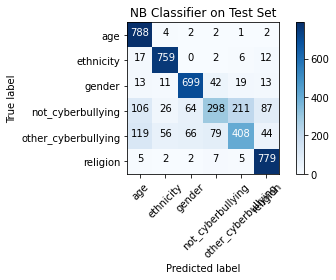

In [19]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

## KNN - estimators downwoards not used yet 

In [ ]:
# Optimize parameters for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_neighbors': [5, 10, 15, 20, 25],
    'estimator__weights': ['uniform','distance'],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("KNN : {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_knn, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_knn, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', KNeighborsClassifier())])
Fitting 8 folds for each of 960 candidates, totalling 7680 fits
--- 3711.2523951530457 seconds ---
KNN : 45.52498185215394% F1-score for class 'hate-speech' with parameters {'estimator__algorithm': 'auto', 'estimator__n_neighbors': 10, 'estimator__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True}


['/content/drive/My Drive/team project/codes/models/knn.pkl']

              precision    recall  f1-score   support

           0       0.98      0.82      0.90      2971
           1       0.26      0.83      0.39       224

    accuracy                           0.82      3195
   macro avg       0.62      0.82      0.64      3195
weighted avg       0.93      0.82      0.86      3195



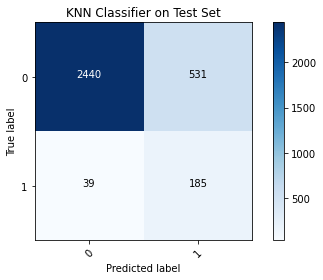

In [ ]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "KNN Classifier on Test Set")
print(classification_report(y_test, prediction))

## Random Forest

In [ ]:
# Optimize parameters for Random Forest
estimator = RandomForestClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Random Forest Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_rf, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_rf, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', RandomForestClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.4639124  0.46547152 0.46023681 ...        nan        nan        nan]
  category=UserWarning


--- 2344.0287425518036 seconds ---
Random Forest Classifier: 53.37193506504465% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800, 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/team project/codes/models/rf.pkl']

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2971
           1       0.41      0.71      0.52       224

    accuracy                           0.91      3195
   macro avg       0.69      0.81      0.73      3195
weighted avg       0.94      0.91      0.92      3195



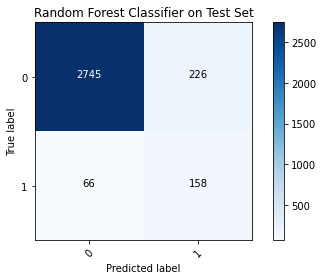

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Random Forest Classifier on Test Set")
print(classification_report(y_test, prediction))


## Extra Trees

In [ ]:
# Optimize parameters for Extra Trees
estimator = ExtraTreesClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Extra Trees Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_et, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_et, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', ExtraTreesClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.45371934 0.44843191 0.46492321 ...        nan        nan        nan]
  category=UserWarning


--- 2749.808964729309 seconds ---
Extra Trees Classifier: 56.88402752771815% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 15, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/home/v.zevallosm/team project/codes/models/et.pkl']

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2971
           1       0.50      0.69      0.58       224

    accuracy                           0.93      3195
   macro avg       0.74      0.82      0.77      3195
weighted avg       0.94      0.93      0.94      3195



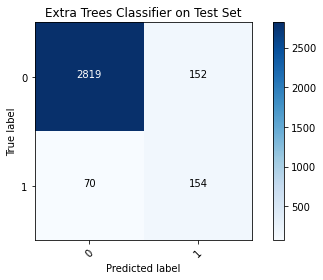

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Extra Trees Classifier on Test Set")
print(classification_report(y_test, prediction))


## SGD

In [ ]:
# Optimize parameters for SGDClassifier
estimator = SGDClassifier(max_iter=5000, random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge','modified_huber','perceptron','squared_hinge'],
    'estimator__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'estimator__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("SGDClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_sgd, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_sgd, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', SGDClassifier(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 4608 candidates, totalling 36864 fits
--- 11506.218701601028 seconds ---
SGDClassifier: 58.36113514801878% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 0.001, 'estimator__loss': 'hinge', 'estimator__tol': 0.01, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/sgd.pkl']

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2971
           1       0.47      0.75      0.57       224

    accuracy                           0.92      3195
   macro avg       0.72      0.84      0.77      3195
weighted avg       0.94      0.92      0.93      3195



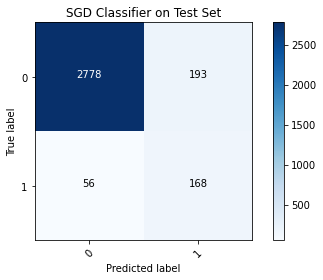

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "SGD Classifier on Test Set")
print(classification_report(y_test, prediction))


## SVM

In [ ]:
# Optimize parameters for LSVM Classifier
estimator = LinearSVC(max_iter=5000, random_state=42, dual = True)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("LSVM Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_svm, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_svm, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LinearSVC(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 1680 candidates, totalling 13440 fits
--- 6578.054311037064 seconds ---
LSVM Classifier: 59.11648971569943% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.1, 'estimator__loss': 'hinge', 'estimator__tol': 0.001, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/svm.pkl']

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2971
           1       0.57      0.60      0.59       224

    accuracy                           0.94      3195
   macro avg       0.77      0.78      0.78      3195
weighted avg       0.94      0.94      0.94      3195



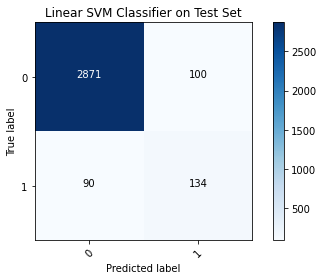

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Linear SVM Classifier on Test Set")
print(classification_report(y_test, prediction))


## Logistic Regression

In [ ]:
# Optimize parameters for Logistic Regression
estimator = LogisticRegression()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__penalty': [ 'l2', 'none'],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__C': [100, 10, 1.0, 0.1, 0.01]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Logistic Regression Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_lr, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_lr, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LogisticRegression())])
Fitting 8 folds for each of 1200 candidates, totalling 9600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
960 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

--- 3418.477582216263 seconds ---
Logistic Regression Classifier: 56.512767626947344% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg', 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/lr.pkl']

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2971
           1       0.41      0.79      0.54       224

    accuracy                           0.91      3195
   macro avg       0.70      0.85      0.75      3195
weighted avg       0.94      0.91      0.92      3195



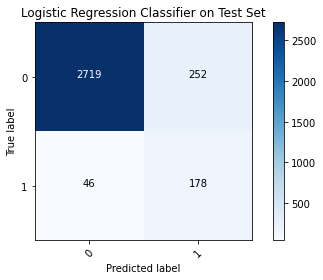

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Logistic Regression Classifier on Test Set")
print(classification_report(y_test, prediction))

## Decision Tree

In [ ]:
# Optimize parameters for simple Decision Tree
estimator = DecisionTreeClassifier(random_state=101)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.3, 0.6, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__splitter' : ['best', 'random'],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Decision Tree Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_dt, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_dt, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', DecisionTreeClassifier(random_state=101))])
Fitting 8 folds for each of 972 candidates, totalling 7776 fits
--- 2684.384980916977 seconds ---
Decision Tree Classifier: 47.275311076294436% F1-score for class 'hate-speech' with parameters {'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 25, 'estimator__splitter': 'best', 'vectorizer__max_df': 0.3, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/dt.pkl']

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2971
           1       0.41      0.50      0.45       224

    accuracy                           0.91      3195
   macro avg       0.69      0.72      0.70      3195
weighted avg       0.92      0.91      0.92      3195



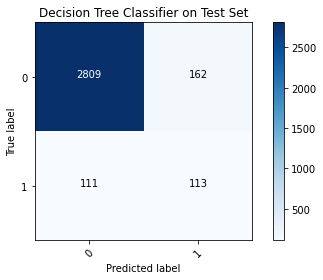

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Decision Tree Classifier on Test Set")
print(classification_report(y_test, prediction))